# __[ LG Energy Solution ] <br><br>Anomaly Detection Part2: LOF, iForest, AE__

# <br>__1. Data: NASA Bearing Dataset__

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Step1. 데이터 불러오기

In [2]:
# 데이터 불러오기
data = pd.read_csv('./data/nasa_bearing_dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0,train
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0,train
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0,train
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0,train
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0,train


### Step2. 데이터 Split

In [3]:
X_train = data[data['data_type'] == 'train'].iloc[:, :4]
y_train = data[data['data_type'] == 'train'].iloc[:, -2].values

X_test = data[data['data_type'] == 'test'].iloc[:, :4]
y_test = data[data['data_type'] == 'test'].iloc[:, -2].values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Test data shape: (492, 4)


---

# __<br> 2. Local Oulier Factor__

### Local Outlier Factor (LOF)
>이상치 스코어를 산출할 떄 주변부 데이터의 밀도를 고려하고자 함

<img src="https://i.imgur.com/flXG1jT.jpg" width="450">

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

### Step 0. 데이터 정규화

In [5]:
# train 데이터를 기반으로 train/test 데이터에 대하여 standard scaling 적용 (평균 0, 분산 1) 
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [6]:
lof_X_train = pd.DataFrame(scaler.transform(X_train), 
                           columns=X_train.columns, index=X_train.index)
lof_X_test = pd.DataFrame(scaler.transform(X_test), 
                          columns=X_test.columns, index=X_test.index)

### Step 1. Train 데이터 기반 모델 적합

- LocalOutlierFactor 설명
    - n_neighbors: neighbors 개수. 디폴트 20
    - algorithm: nearest neighbors 계산 방법 ('auto', 'ball_tree', 'kd_tree', 'brute'}. 디폴트 'auto'
    - metric: distance 계산 방법. 디폴트 'minkowski'
    - novelty: True (for novelty detection - no oulier in train data), False (for outlier detection - ouliers in train data). 디폴트 False

In [7]:
# LOF 모델 적합
lof_model = LocalOutlierFactor(n_neighbors=5, novelty=True)
lof_model.fit(lof_X_train)

LocalOutlierFactor(n_neighbors=5, novelty=True)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [8]:
# train/test 데이터의 LOF score 도출
lof_train = - 1.0 * lof_model.score_samples(lof_X_train)
lof_test = - 1.0 * lof_model.score_samples(lof_X_test)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

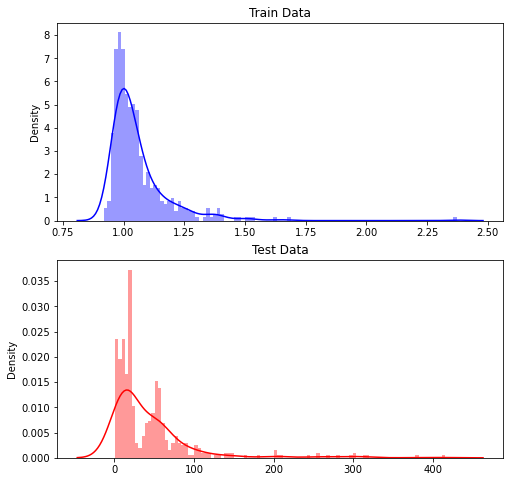

In [9]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(lof_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(lof_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [10]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0.5
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [11]:
# best threshold 도출
lof_best_threshold = search_best_threshold(lof_test, y_test, num_step=1000)

Best threshold:  15.0509
Best F1 Score: 0.9291


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [12]:
# 최종 결과 도출
lof_scores = pd.DataFrame(index=data.index)
lof_scores['score'] = list(np.hstack([lof_train, lof_test]))
lof_scores['anomaly'] = lof_best_threshold < lof_scores['score']
lof_scores.head()

,score,anomaly
2004-02-12 10:32:39,2.371053,False
2004-02-12 10:42:39,1.674762,False
2004-02-12 10:52:39,1.250015,False
2004-02-12 11:02:39,1.218462,False
2004-02-12 11:12:39,1.347574,False


In [13]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(data.index[int(len(data) * 0.5)], c='orange', ls='--')
    plt.axvline(data.index[int(len(data) * 0.7)], c='orange', ls='--')
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

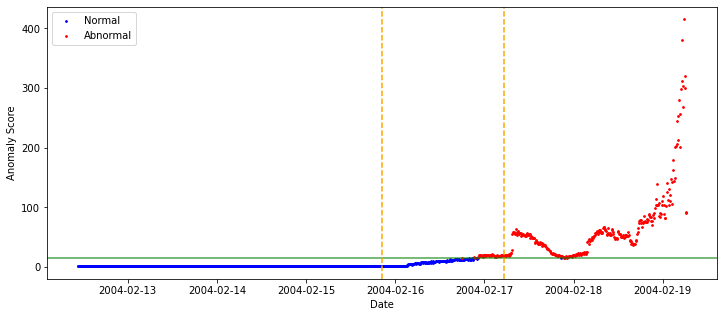

In [14]:
# 전체 데이터의 anomaly score 확인
draw_plot(lof_scores, lof_best_threshold)

In [15]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [16]:
# F1 Score: 0.9291
frr, far, f1 = calculate_metric(y_test, lof_scores['anomaly'].iloc[int(len(data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.2245  |  FAR: 0.0034  |  F1 Score: 0.9291


# __<br>3. Isolation Forest__

### Isolation Forest
>하나의 객체를 고립시키는 의사결정나무를 생성하여 이상치를 탐지하고자 함 <br>
>정상 데이터는 고립시키는데 많은 분기가 필요하지만, 이상치 데이터라면 상대적으로 적은 분기만으로 고립이 가능함

<img src="https://i.imgur.com/VVbACBB.jpg" width="700">

In [17]:
from sklearn.ensemble import IsolationForest

### Step 1. Train 데이터 기반 모델 적합

- IsolationForest 설명
    - n_estimators: 트리 개수. 디폴트 100
    - bootstrap: 데이터의 중복 사용 여부. 디폴트 False
    - max_samples: 데이터 샘플 중 선택할 샘플의 수 혹은 비율 ('auto': max_samples=min(256, n_samples)) . 디폴트 'auto'

In [18]:
if_model = IsolationForest(random_state=42)
if_model.fit(X_train)

IsolationForest(random_state=42)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [19]:
# train 데이터의 IF score 도출
if_train = - 1.0 * if_model.score_samples(X_train)
if_test = - 1.0 * if_model.score_samples(X_test)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

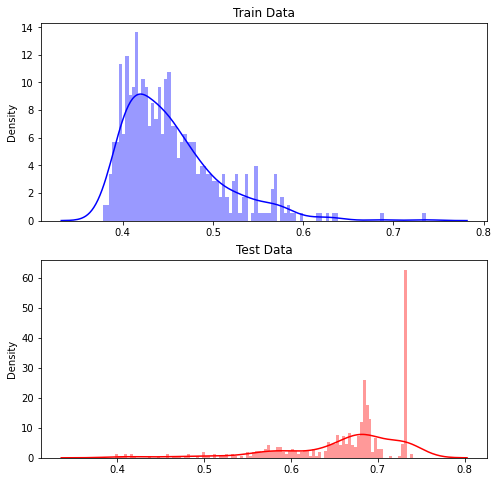

In [20]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(if_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(if_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [21]:
# best threshold 도출
if_best_threshold = search_best_threshold(if_test, y_test, num_step=1000)

Best threshold:  0.6723
Best F1 Score: 0.9457


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [22]:
# 최종 결과 도출
if_scores = pd.DataFrame(index=data.index)
if_scores['score'] = list(np.hstack([if_train, if_test]))
if_scores['anomaly'] = if_best_threshold < if_scores['score']
if_scores.head()

,score,anomaly
2004-02-12 10:32:39,0.735772,True
2004-02-12 10:42:39,0.635403,False
2004-02-12 10:52:39,0.566701,False
2004-02-12 11:02:39,0.635642,False
2004-02-12 11:12:39,0.548939,False


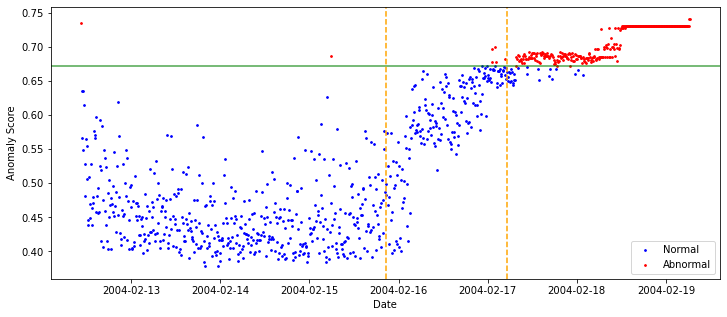

In [23]:
# 전체 데이터의 anomaly score 확인
draw_plot(if_scores, if_best_threshold)

In [24]:
# F1 Score: 0.9457
frr, far, f1 = calculate_metric(y_test, if_scores['anomaly'].iloc[int(len(data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.0255  |  FAR: 0.0878  |  F1 Score: 0.9457


---

# __4. Auto-Encoder__

### Auto-Encoder (Auto-Associative Neural Network)
>입력과 출력이 동일한 인공신경망 구조 <br>
>정상 데이터에 대한 학습이 충분히 되어 있을 경우 정상 데이터는 자기 자신을 잘 복원할 수 있지만, 이상치 제이터는 학습 기회가 적어 상대적으로 잘 복원하지 못할 것을 가정

<img src="https://i.imgur.com/DTgug9o.jpg" width="700">

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

In [26]:
# hyper-parameter 설정
input_size = 4
hidden_size = 2

num_epochs = 20
batch_size = 32
learning_rate = 0.001

device = 'cpu'

### Step0. 데이터 정규화

In [27]:
# train 데이터를 기반으로 train/test 데이터에 대하여 min-max scaling 적용 
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

In [28]:
ae_X_train = scaler.transform(X_train)
ae_X_test = scaler.transform(X_test)

### Step 1. DataLoader 만들기 (Custom dataset)

In [29]:
class AE_CustomDataset(Dataset): 
    def __init__(self, data):
        self.data = data

    # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.data[idx])
        return x

In [30]:
ae_train_dataset = AE_CustomDataset(ae_X_train)
ae_train_loader = DataLoader(ae_train_dataset, batch_size=batch_size, shuffle=True)

ae_test_dataset = AE_CustomDataset(ae_X_test)
ae_test_loader = DataLoader(ae_test_dataset, batch_size=batch_size, shuffle=False)

### Step 2. 모델 구축

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU()
        )
        self.decoder = nn.Sequential(
          nn.Linear(hidden_size, input_size)
        )
        
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        out = F.sigmoid(out)
        return out

In [32]:
ae_model = AutoEncoder(input_size, hidden_size)

In [33]:
ae_model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
  )
)

### Step 3. Train 데이터로 모델 학습

In [34]:
# model 학습
def train_model(data_loader, model, criterion, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(num_epochs):
        for i, x in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, x)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 5 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, len(data_loader), loss.item()))
    
    return model

In [35]:
ae_train_criterion = nn.MSELoss()
ae_model = train_model(ae_train_loader, ae_model, ae_train_criterion, num_epochs, learning_rate, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20], Step [5/16], Loss: 0.0456
Epoch [1/20], Step [10/16], Loss: 0.0425
Epoch [1/20], Step [15/16], Loss: 0.0331
Epoch [2/20], Step [5/16], Loss: 0.0408
Epoch [2/20], Step [10/16], Loss: 0.0348
Epoch [2/20], Step [15/16], Loss: 0.0328
Epoch [3/20], Step [5/16], Loss: 0.0387
Epoch [3/20], Step [10/16], Loss: 0.0438
Epoch [3/20], Step [15/16], Loss: 0.0354
Epoch [4/20], Step [5/16], Loss: 0.0370
Epoch [4/20], Step [10/16], Loss: 0.0321
Epoch [4/20], Step [15/16], Loss: 0.0320
Epoch [5/20], Step [5/16], Loss: 0.0392
Epoch [5/20], Step [10/16], Loss: 0.0419
Epoch [5/20], Step [15/16], Loss: 0.0339
Epoch [6/20], Step [5/16], Loss: 0.0332
Epoch [6/20], Step [10/16], Loss: 0.0307
Epoch [6/20], Step [15/16], Loss: 0.0382
Epoch [7/20], Step [5/16], Loss: 0.0284
Epoch [7/20], Step [10/16], Loss: 0.0330
Epoch [7/20], Step [15/16], Loss: 0.0428
Epoch [8/20], Step [5/16], Loss: 0.0294
Epoch [8/20], Step [10/16], Loss: 0.0363
Epoch [8/20], Step [15/16], Loss: 0.0354
Epoch [9/20], Step [5/16

### Step 4. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출 (Inference)

In [36]:
# model inference
def inference_model(data_loader, model, criterion, device):
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        infer_loss = []
        for i, x in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            output = model(x)
            loss = criterion(output, x)
            loss = loss.reshape(loss.shape[0], -1).mean(axis=1)

            infer_loss += list(loss.data.numpy())
    return infer_loss

In [37]:
# train 데이터에 대한 최종 결과 도출
ae_infer_criterion = nn.L1Loss(reduction='none')
ae_train_loss = inference_model(ae_train_loader, ae_model, ae_infer_criterion, device)
ae_test_loss = inference_model(ae_test_loader, ae_model, ae_infer_criterion, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

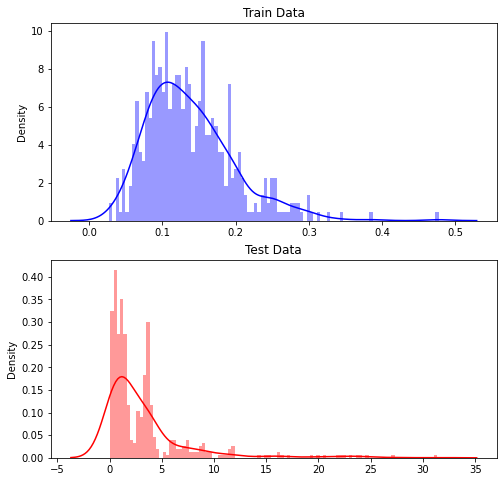

In [38]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(ae_train_loss, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(ae_test_loss, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 5. Threshold 탐색

In [39]:
# best threshold 도출
ae_best_threshold = search_best_threshold(ae_test_loss, y_test, num_step=1000)

Best threshold:  1.2988
Best F1 Score: 0.9795


### Step 6. Best threshold를 기반으로 이상치 탐지 모형 평가

In [40]:
# 최종 결과 도출
ae_scores = pd.DataFrame(index=data.index)
ae_scores['score'] = list(np.hstack([ae_train_loss, ae_test_loss]))
ae_scores['anomaly'] = ae_best_threshold < ae_scores['score']
ae_scores.head()

,score,anomaly
2004-02-12 10:32:39,0.084051,False
2004-02-12 10:42:39,0.095987,False
2004-02-12 10:52:39,0.135149,False
2004-02-12 11:02:39,0.174822,False
2004-02-12 11:12:39,0.113449,False


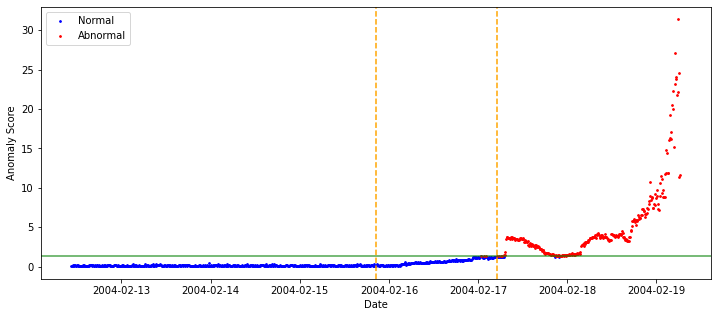

In [41]:
# 전체 데이터의 anomaly score 확인
draw_plot(ae_scores, ae_best_threshold)

In [42]:
# F1 Score: 0.9795
frr, far, f1 = calculate_metric(y_test, ae_scores['anomaly'].iloc[int(len(data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.0153  |  FAR: 0.0304  |  F1 Score: 0.9795


---